# ニューラルネットワーク (1)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML
from sklearn.linear_model import SGDClassifier
from schemdraw.parsing import logicparse

2010年頃からの深層学習の急速な発展は、第3次人工知能（AI）ブームをもたらした。2012年にILSVRCというコンペティションで画像分類の精度を大幅に向上させ、2016年にAlpha Goが世界チャンピオンに勝利するなど、深層学習は様々な分野で多くのブレークスルーを生み出した。

深層学習は、**ニューラルネットワーク**（neural network）と呼ばれるアーキテクチャで実現される。実は、これまでに説明した単回帰、重回帰、線形分類モデルは、一つの層から構成されるニューラルネットワーク、すなわち**単層ニューラルネットワーク**（single-layer neural network）と見なすことができる。また、ニューラルネットワークの学習には確率的勾配降下法（SGD）、およびその亜種（RMSPropやAdamなど）が用いられる。したがって、これまでの章で説明した内容で、ニューラルネットワークの基礎事項の半分以上はカバーされていると考えてよい。

本章では、複数の線形二値分類モデルを積み重ねることを通して、**多層ニューラルネットワーク**（multi-layer neural network）および**順伝播型ニューラルネットワーク**（feedforward neural network）を導入する。さらに、多層ニューラルネットワークは任意のブール関数や連続関数を近似的に表現する能力を持つことを説明する。なお、内容が盛り沢山となってしまったため、ニューラルネットワークの学習に関する話題は次章で説明する。

<a id="f7-0"></a>
(7.0)  

## 閾値論理ユニット

線形二値分類は、$d$次元ベクトルの入力$\pmb{x} \in \mathbb{R}^{d}$からラベル$\hat{y} \in \{0, 1\}$を計算するモデルである。ここで$d = 2$とし、2個のブール変数$x_1, x_2 \in \{0, 1\}$から1個の出力$\hat{y} \in \{0, 1\}$を得るモデルを考えたい。モデルのパラメータとして、2個の入力に対する重みを$w_1, w_2 \in \mathbb{R}$、バイアスを$b \in \mathbb{R}$とおくと、ラベル$\hat{y}$は次式で計算される。

<a id="f7-1"></a>
(7.1)  
$$
\begin{gather}
    \hat{y} = \begin{cases}
        1 & \left(w_1 x_1 + w_2 x_2 + b > 0\right) \\
        0 & (\mbox{それ以外})
    \end{cases}
\end{gather}
$$


教師あり学習は、入力と出力の組に対応する訓練データ$\mathcal{D}$が与えられたとき、その入力と出力を結びつける写像を学習で求める枠組みであった。本節では、どのような訓練データであってもそれを再現する線形二値分類モデルを学習できるのか、もし再現できない場合は訓練データがどのような性質を持つのか、掘り下げていきたい。

なお、訓練データ$\mathcal{D}$にはすべての入出力の組み合わせが収録されていると仮定する。今回の場合は、入力変数が2つあり、それぞれが$0$または$1$の値を取り得るので、入力として$2 \times 2 = 4$通りの組み合わせが存在する。ゆえに、訓練データの事例数は$4$である。訓練データ$\mathcal{D}$は論理関数$f: \{0, 1\}^2 \longmapsto \{0, 1\}$の真理値表と見なすこともできる。したがって、本節で取り扱いたい問いは、2入力1出力の論理関数の真理値表が与えられたとき、対応する論理関数を線形二値分類モデルの学習で自動的に求めることができるか、ということになる。

### 論理積

最初に、線形二値分類モデルで論理積（AND）の入出力を学習できるかを確認する。二つの入力$x_1$と$x_2$に対して、その論理積をとったものを出力$y$とすると、$y = x_1 \wedge x_2$である。論理回路では以下の記号で表される。

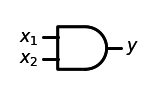

In [2]:
logicparse('$x_1$ and $x_2$', outlabel='$y$')

論理積の真理値表は以下の通りである。

| $x_1$ | $x_2$ | $y$ |
| :---: |:-----:|:---:|
| 0 | 0 | 0 |
| 0 | 1 | 0 |
| 1 | 0 | 0 |
| 1 | 1 | 1 |

これを訓練データに変換すると、

<a id="f7-2"></a>
(7.2)  
\begin{align}
\mathcal{D} = \{((0, 0), 0), ((0, 1), 0), ((1, 0), 0), ((1, 1), 1)\}
\end{align}

である。この訓練データに対して、線形二値分類モデルを[sklearn.linear_model.SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)で学習する。

In [3]:
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
Y = np.array([0, 0, 0, 1])
mAND = SGDClassifier(loss='log_loss')
mAND.fit(X, Y)

SGDClassifier(loss='log_loss')

以下のとおり、この線形二値分類モデルが論理積の入出力を再現していることを確認できる。

In [4]:
mAND.predict(X)

array([0, 0, 0, 1])

$x_1$を横軸、$x_2$を縦軸として、学習した線形二値分類モデルの出力を可視化する。モデルが$\hat{y}=0$と予測する領域は点（青色）で、$\hat{y}=1$と予測する領域は○印（赤色）で塗りつぶした。$(x_1, x_2) = (0, 0), (0, 1), (1, 0), (1, 1)$などの入力に対して、$y=0$となるべき点は－印、$y=1$となるべき点を＋印で示している。$(0, 0), (0, 1), (1, 0)$などの入力では$0$を出力し、$(1, 1)$の入力では$1$を出力することを確認できる。したがって、線形二値分類モデルは論理積の入出力を再現できる。

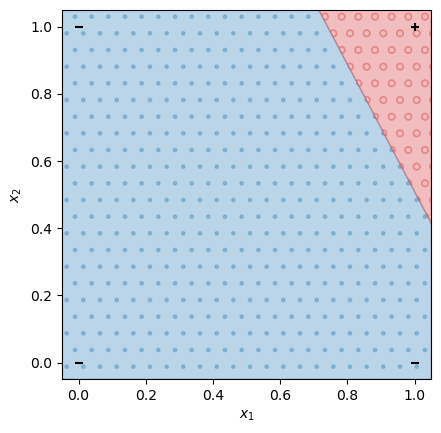

In [5]:
def draw_decision_area(ax, model, X, vmin, vmax):
    w1, w2 = model.coef_[0]
    bias = model.intercept_[0]
    a = -w1 / w2
    b = -bias / w2
    if bias <= 0:
        ax.fill_between(X, vmin, a * X + b, color='tab:blue', hatch='.', alpha=0.3)
        ax.fill_between(X, a * X + b, vmax, color='tab:red', hatch='o', alpha=0.3)
    else:
        ax.fill_between(X, vmin, a * X + b, color='tab:red', hatch='o', alpha=0.3)
        ax.fill_between(X, a * X + b, vmax, color='tab:blue', hatch='.', alpha=0.3)
        
def draw_points(ax, Xp, Yp):
    colors = np.array(["tab:blue", "tab:red"])
    I = np.where(Yp == 0)
    ax.scatter(Xp[I,0], Xp[I,1], c='black', marker='_')
    I = np.where(Yp == 1)
    ax.scatter(Xp[I,0], Xp[I,1], c='black', marker='+')

def show_decisions(model, Xp, Yp, N=400):
    vmin = -0.05
    vmax = 1.05
    fig, ax = plt.subplots(dpi=100)
    ax.set_aspect('equal')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_xlim(vmin, vmax)
    ax.set_ylim(vmin, vmax)
    X = np.linspace(vmin, vmax, N)
    draw_decision_area(ax, model, X, vmin, vmax)
    draw_points(ax, Xp, Yp)
    plt.show()

show_decisions(mAND, X, Y)

学習で自動的に求められた線形二値分類モデルのパラメータ$w_1, w_2, b$は以下の通りである。

In [6]:
mAND.coef_, mAND.intercept_

(array([[19.30395107, 10.17835825]]), array([-24.47778913]))

### 論理和

続いて、線形二値分類モデルで論理和（OR）の入出力を学習できるかを確認する。二つの入力$x_1$と$x_2$に対して、その論理和をとったものを出力$y$とすると、$y = x_1 \vee x_2$である。論理回路では以下の記号で表される。

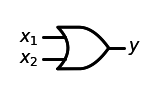

In [7]:
logicparse('$x_1$ or $x_2$', outlabel='$y$')

論理和の真理値表は以下の通りである。

| $x_1$ | $x_2$ | $y$ |
| :---: |:-----:|:---:|
| 0 | 0 | 0 |
| 0 | 1 | 1 |
| 1 | 0 | 1 |
| 1 | 1 | 1 |

これを訓練データに変換すると、

<a id="f7-3"></a>
(7.3)  
\begin{align}
\mathcal{D} = \{((0, 0), 0), ((0, 1), 1), ((1, 0), 1), ((1, 1), 1)\}
\end{align}

である。この訓練データに対して、線形二値分類モデルを[sklearn.linear_model.SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)で学習する。

In [8]:
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
Y = np.array([0, 1, 1, 1])
mOR = SGDClassifier(loss='log_loss')
mOR.fit(X, Y)

SGDClassifier(loss='log_loss')

以下のとおり、この線形二値分類モデルが論理和の入出力を再現していることを確認できる。

In [9]:
mOR.predict(X)

array([0, 1, 1, 1])

$x_1$を横軸、$x_2$を縦軸として、学習した線形二値分類モデルの出力を可視化する。$(0, 0)$の入力では$0$を出力し、$(0, 1), (1, 0), (1, 1)$などの入力では$1$を出力することを確認できる。したがって、線形二値分類モデルは論理和の入出力を再現できる。

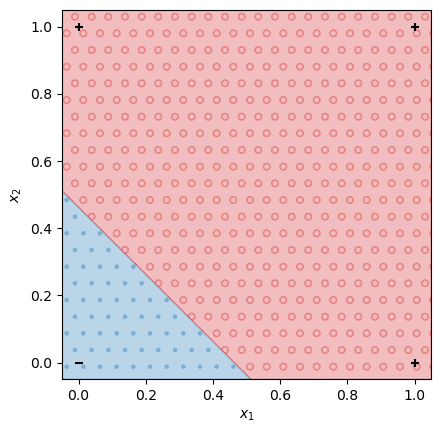

In [10]:
show_decisions(mOR, X, Y)

学習で自動的に求められた線形二値分類モデルのパラメータ$w_1, w_2, b$は以下の通りである。

In [11]:
mOR.coef_, mOR.intercept_

(array([[10.01231916, 10.03286418]]), array([-4.63420621]))

### 否定

さらに、線形二値分類モデルで否定（NOT）の入出力を学習できるかを確認する。論理積や論理和では入力が二つあったが、否定の入力は一つである。入力$x$に対して、その否定をとったものを出力$y$とすると、$y = \lnot x$である。論理回路では以下の記号で表される。

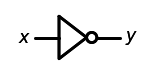

In [12]:
logicparse('not $x$', outlabel='$y$')

否定の真理値表は以下の通りである。

| $x$ | $y$ |
| :---: |:---:|
| 0 | 1 |
| 1 | 0 |

これを訓練データに変換すると、

<a id="f7-4"></a>
(7.4)  
\begin{align}
\mathcal{D} = \{(0, 1), (1, 0)\}
\end{align}

である。この訓練データに対して、線形二値分類モデルを[sklearn.linear_model.SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)で学習する。

In [13]:
X = np.array([[0], [1]])
Y = np.array([1, 0])
mNOT = SGDClassifier(loss='log_loss')
mNOT.fit(X, Y)

SGDClassifier(loss='log_loss')

以下のとおり、この線形二値分類モデルが否定の入出力を再現していることを確認できる。

In [14]:
mNOT.predict(X)

array([1, 0])

入力を横軸、出力を縦軸としてプロットする。$0$の入力では$1$を出力し、$1$の入力では$0$を出力することを確認できる。したがって、線形二値分類モデルは否定の入出力を再現できる。

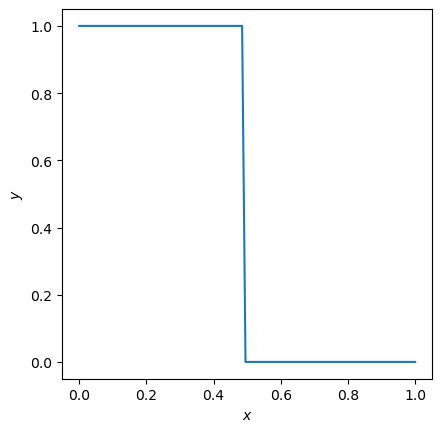

In [15]:
N = 100
X = np.linspace(0, 1, N).reshape(N, -1)
P = mNOT.predict(X)

fig, ax = plt.subplots(dpi=100)
ax.set_aspect('equal')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.plot(X, P)
plt.show()

学習で自動的に求められた線形二値分類モデルの重みとバイアスは以下の通りである。

In [16]:
mNOT.coef_, mNOT.intercept_

(array([[-10.22164928]]), array([5.01662327]))

### 否定論理積

ついでに、線形二値分類モデルで否定論理積（NAND）の入出力を学習できるかを確認する。二つの入力$x_1$と$x_2$に対して、その否定論理積をとったものを出力$y$とすると、$y = \lnot (x_1 \wedge x_2)$である。論理回路では以下の記号で表される

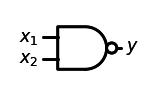

In [17]:
logicparse('$x_1$ nand $x_2$', outlabel='$y$')

否定論理積の真理値表は以下の通りである。

| $x_1$ | $x_2$ | $y$ |
| :---: |:-----:|:---:|
| 0 | 0 | 1 |
| 0 | 1 | 1 |
| 1 | 0 | 1 |
| 1 | 1 | 0 |

これを訓練データに変換すると、

<a id="f7-5"></a>
(7.5)  
\begin{align}
\mathcal{D} = \{((0, 0), 1), ((0, 1), 1), ((1, 0), 1), ((1, 1), 0)\}
\end{align}

である。この訓練データに対して、線形二値分類モデルを[sklearn.linear_model.SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)で学習する。

In [18]:
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
Y = np.array([1, 1, 1, 0])
mNAND = SGDClassifier(loss='log_loss')
mNAND.fit(X, Y)

SGDClassifier(loss='log_loss')

以下のとおり、この線形二値分類モデルが否定論理積の入出力を再現していることを確認できる。

In [19]:
mNAND.predict(X)

array([1, 1, 1, 0])

$x_1$を横軸、$x_2$を縦軸として、学習した線形二値分類モデルの出力を可視化する。$(0, 0)$の入力では$1$を出力し、$(0, 1), (1, 0), (1, 1)$の入力では$0$を出力することを確認できる。したがって、線形二値分類モデルは否定論理積の入出力を再現できる。

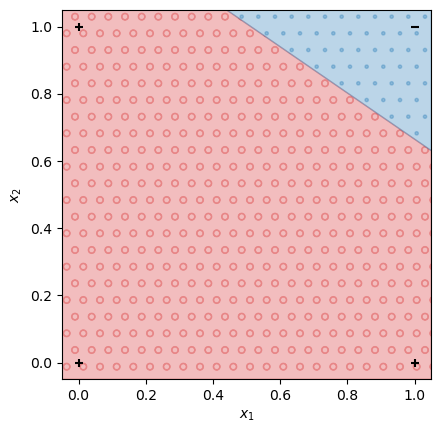

In [20]:
show_decisions(mNAND, X, Y)

学習で自動的に求められた線形二値分類モデルのパラメータ$w_1, w_2, b$は以下の通りである。

In [21]:
mNAND.coef_, mNAND.intercept_

(array([[ -9.99383298, -14.53626612]]), array([19.65611917]))

### 排他的論理和

では、排他的論理和（XOR）はどうであろうか。二つの入力$x_1$と$x_2$に対して、その排他的論理和をとったものを出力$y$とすると、$y = x_1 \oplus x_2$である。論理回路では以下の記号で表される。

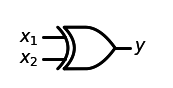

In [22]:
logicparse('$x_1$ xor $x_2$', outlabel='$y$')


---

【補足】排他的論理和（XOR）  
- 値が異なる場合は1  
- 値が同じ場合は0  


---

排他的論理和の真理値表は以下の通りである。

| $x_1$ | $x_2$ | $y$ |
| :---: |:-----:|:---:|
| 0 | 0 | 0 |
| 0 | 1 | 1 |
| 1 | 0 | 1 |
| 1 | 1 | 0 |

論理和との差は、$x_1 = 1, x_2 = 1$のときに$y=0$となる点である。両方の入力が等しいときに$0$、異なるときに$1$を返すことから「排他的」と呼ばれる。

これを訓練データに変換すると、

<a id="f7-6"></a>
(7.6)  
\begin{align}
\mathcal{D} = \{((0, 0), 0), ((0, 1), 1), ((1, 0), 1), ((1, 1), 0)\}
\end{align}

である。この訓練データに対して、線形二値分類モデルを[sklearn.linear_model.SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)で学習する。

In [23]:
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
Y = np.array([0, 1, 1, 0])
mXOR = SGDClassifier(loss='log_loss')
mXOR.fit(X, Y)

SGDClassifier(loss='log_loss')

これまで通りモデルを学習できたように見えるが、**学習で得られたモデルは排他的論理和の入出力を再現できていない**。以下のセルの出力は`0, 1, 1, 0`となるべきであるが、その通りの出力が得られない。

In [24]:
mXOR.predict(X)

array([1, 0, 0, 0])

$x_1$を横軸、$x_2$を縦軸として、学習した線形二値分類モデルの出力を可視化する。この可視化結果からも、学習した線形二値分類モデルが排他的論理和の入出力を再現できていないことが分かる。したがって、線形二値分類モデルは排他的論理和を表現することができない。

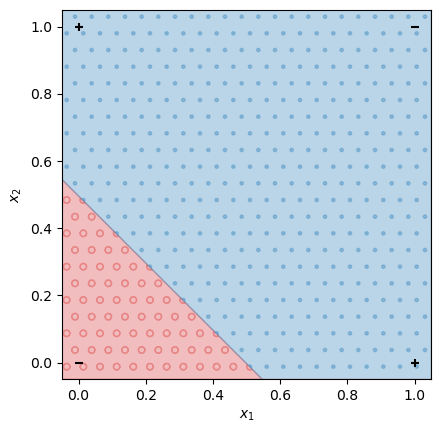

In [25]:
show_decisions(mXOR, X, Y)

参考までに、学習で自動的に求められた線形二値分類モデルのパラメータ$w_1, w_2, b$を示す。

In [26]:
mXOR.coef_, mXOR.intercept_

(array([[-9.81583037, -9.83684735]]), array([4.87360617]))

### 線形分離可能・不能

なぜ線形二値分類モデルでは排他的論理和を表現できないのか？　その答えは、式[(7.1)](#f7-1)の条件式から導くことができる。式[(7.1)](#f7-1)より、入力$x_1, x_2$が$\hat{y}=1$に分類される条件は、

<a id="f7-7"></a>
(7.7)  
\begin{align}
w_1 x_1 + w_2 x_2 + b &> 0 \\
x_2 &> -\frac{w_1}{w_2}x_1 -\frac{b}{w_2}
\end{align}

この条件を$x_1$－$x_2$平面上で図示する。訓練データでモデルのパラメータを学習すると、パラメータ$w_1, w_2, b$が決まる。これらのパラメータの値に基づき、$x_1$－$x_2$平面上に直線$x_2 = -\frac{w_1}{w_2}x_1 -\frac{b}{w_2}$を引く。モデルへの入力$x_1, x_2$を点$(x_1, x_2)$で表現したとき、その点が直線よりも上側にあるときは$\hat{y} = 1$、下側にあるときは$\hat{y} = 0$に分類される。このように、$x_1$と$x_2$の2入力の線形二値分類モデルを学習することは、$x_1$－$x_2$平面上で出力を分離する直線を求めることに相当する。

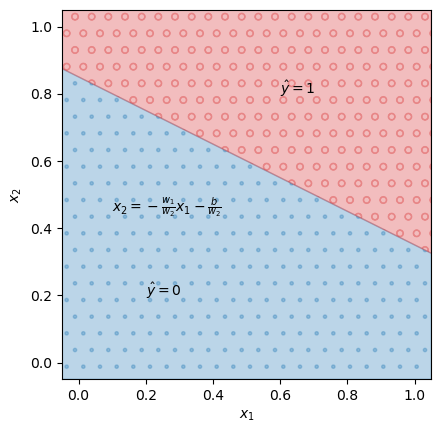

In [27]:
class Model: pass

model = Model()
model.coef_ = np.array([[1., 2.]])
model.intercept_ = np.array([-1.7])

N = 400
vmin = -0.05
vmax = 1.05
fig, ax = plt.subplots(dpi=100)
ax.set_aspect('equal')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_xlim(vmin, vmax)
ax.set_ylim(vmin, vmax)
X = np.linspace(vmin, vmax, N)
draw_decision_area(ax, model, X, vmin, vmax)

ax.text(0.6, 0.8, '$\hat{y} = 1$')
ax.text(0.2, 0.2, '$\hat{y} = 0$')
ax.text(0.1, 0.45, r'$x_2 = -\frac{w_1}{w_2}x_1 -\frac{b}{w_2}$')
plt.show()

ここから、線形二値分類モデルが排他的論理和を表現できないことを簡単に示すことができる。排他的論理和の入出力を$x_1$－$x_2$平面上で図示すると、次のようになる。

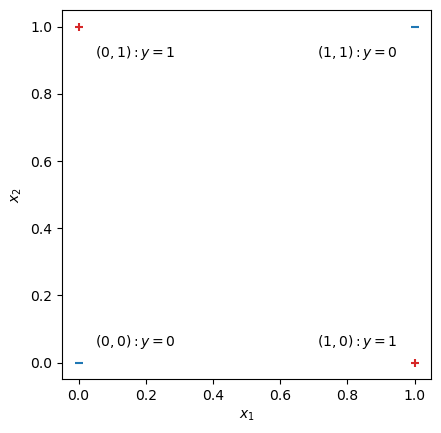

In [28]:
X = np.linspace(0, 1, 100)
Y = -0.4 * X + 0.7

fig, ax = plt.subplots(dpi=100)
ax.set_aspect('equal')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.scatter([0, 1], [0, 1], c='tab:blue', marker='_')
ax.scatter([0, 1], [1, 0], c='tab:red', marker='+')
ax.text(0.05, 0.05, r'$(0, 0): y = 0$')
ax.text(0.05, 0.95, r'$(0, 1): y = 1$', va='top')
ax.text(0.95, 0.05, r'$(1, 0): y = 1$', ha='right')
ax.text(0.95, 0.95, r'$(1, 1): y = 0$', va='top', ha='right')
plt.show()

このとき、いかなる直線を考えても$y=0$の点の集合と$y=1$の点の集合を分けることができない（実際に上のグラフ内で赤と青の点を分ける一本の直線を引くことができるか検討せよ）。言い換えれば、線形二値分類モデルは排他的論理和のすべての訓練事例を正しく再現することができない。このように、線形分類モデルで正しく再現できない訓練事例があるとき、その訓練データは**線形分離不能**（linearly inseparable）という。

これまでは2入力の線形二値分類モデルについて議論してきたが、より一般的な線形二値分類モデルに対しても同様の議論が成り立つ。式[(5.1)](#f5-1)より、$d$次元ベクトル$\pmb{x} \in \mathbb{R}^d$を入力とする線形二値分類モデルが出力を$\hat{y} = 0$と$\hat{y} = 1$に分離する境界条件は、

<a id="f7-8"></a>
(7.8)  
\begin{align}
\pmb{x}^{\top} \pmb{w} = 0
\end{align}

ゆえに、各事例はパラメータベクトル$\pmb{w}$と直交する**分離超平面**（separating hyperplane）で分類される。先ほどの2入力の例では、分離超平面は直線であった。

訓練データ$\mathcal{D}$を正しく分類する分離超平面を作ることができないとき、その訓練データは線形分離不能と言われる。より厳密には、二値分類の訓練データ$\mathcal{D}$を$y=0$の事例を集めた集合$\mathcal{D}_0$と、$y=1$の事例を集めた集合$\mathcal{D}_1$に分割したとき、

<a id="f7-9"></a>
(7.9)  
\begin{align}
\mathcal{D}_0 = \{(\pmb{x}, y) \in \mathcal{D} \mid y = 0\} \\
\mathcal{D}_1 = \{(\pmb{x}, y) \in \mathcal{D} \mid y = 1\} \\
\end{align}

$\mathcal{D}_0$と$\mathcal{D}_1$に関して、以下の条件を同時に満たすパラメータ$\pmb{w}$が存在しないとき、訓練データ$\mathcal{D}$は線形分離不能である。

<a id="f7-10"></a>
(7.10)  
\begin{align}
\forall (\pmb{x}, y) \in \mathcal{D}_0: \pmb{x}^{\top} \pmb{w} \leq 0 \\
\forall (\pmb{x}, y) \in \mathcal{D}_1: \pmb{x}^{\top} \pmb{w} > 0
\end{align}

逆に、以上の条件をすべて満たすパラメータ$\pmb{w}$が存在するとき、その訓練データは**線形分離可能**（linearly separable）である。

### 線形二値分類を多段にする

線形二値分類モデルで排他的論理和を表現できないことが分かったが、排他的論理和の入出力を線形二値分類器で再現する方法は無いのだろうか？　ここで、排他的論理和はAND, OR, NANDの組み合わせで

<a id="f7-11"></a>
(7.11)  
$$
\begin{align}
y = (x_1 \vee x_2) \wedge \lnot (x_1 \wedge x_2)
\end{align}
$$

として記述できることに着目する。この論理式は、$x_1$と$x_2$の論理和に対して、両方が真である場合を除外するものである。以下のように論理式を分解して考えてみてもよい。

1. 入力に対して論理和をとる: $h_1 = x_1 \vee x_2$
1. 入力に対して否定論理積をとる: $h_2 = \lnot (x_1 \wedge x_2)$
1. $h_1$と$h_2$の論理積をとる: $y = h_1 \wedge h_2$

真理値表を書くと次のようになる。

| $x_1$ | $x_2$ | $h_1 = x_1 \vee x_2$ | $h_2 = \lnot (x_1 \wedge x_2)$ | $h_1 \wedge h_2$ |
| :---: |:-----:|:--:|:----:|:---:|
| 0 | 0 | 0 | 1 | 0 |
| 0 | 1 | 1 | 1 | 1 |
| 1 | 0 | 1 | 1 | 1 |
| 1 | 1 | 1 | 0 | 0 |

また、これを論理回路として記述したものは以下の通りである。

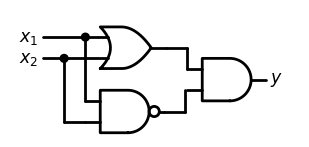

In [29]:
from schemdraw import logic, Drawing

d = Drawing(unit=.5)
S = d.add(logic.OR2)
A = d.add(logic.DOT, xy=S.in1)
d.add(logic.LINE, d='left', l=d.unit*2, lftlabel='$x_1$')
d.add(logic.LINE, d='left', xy=S.in2)
B = d.add(logic.DOT)
d.add(logic.LINE, d='left', lftlabel='$x_2$')

d.add(logic.LINE, d='down', xy=A.start, l=d.unit*3)
C = d.add(logic.NAND2, d='right', anchor='in1')
d.add(logic.LINE, d='down', xy=B.start, toy=C.in2)
d.add(logic.LINE, to=C.in2)

d.add(logic.LINE, d='right', xy=C.out)
d.add(logic.LINE, d='up', l=d.unit)
d.add(logic.LINE, d='right', xy=S.out)
d.add(logic.LINE, d='down', l=d.unit)
z = d.add(logic.AND2, d='right', anchor='in1', rgtlabel='$y$')
d.draw()

これまでの議論により、線形二値分類モデルは論理積（AND）、論理和（OR）、否定論理積（NAND）を表現できることが分かっている。したがって、これらの分類器を組み合わせることにより、排他的論理和を表現できるかもしれない。式[(7.11)](#f7-11)をそのままプログラムとして実装すると、確かに排他的論理和の出力パターンが得られる。

In [30]:
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
Y = np.array([0, 1, 1, 0])
h1 = mOR.predict(X)
h2 = mNAND.predict(X)
print(h1)
print(h2)
mAND.predict(np.array([h1, h2]).T)

[0 1 1 1]
[1 1 1 0]


array([0, 1, 1, 0])

なお、`np.array([h1, h2]).T`の部分は分かりにくいかもしれないので、以下のヒントを示しておく。

In [31]:
np.array([h1, h2])

array([[0, 1, 1, 1],
       [1, 1, 1, 0]])

In [32]:
np.array([h1, h2]).T

array([[0, 1],
       [1, 1],
       [1, 1],
       [1, 0]])

$x_1$を横軸、$x_2$を縦軸として、分類器の組み合わせから得られた出力を可視化してみると、確かに排他的論理和の入出力を再現できていることが分かる。これまでの可視化結果とは異なり、$y=0$と$y=1$を分離する直線が２本現れている所も興味深い。このように、線形二値分類器を多段にすることで、排他的論理和を表現することができた。

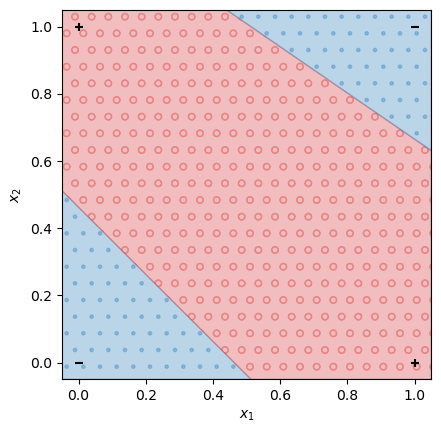

In [33]:
N = 400
vmin = -0.05
vmax = 1.05

X0 = np.linspace(vmin, vmax, N)
w1, w2 = mOR.coef_[0]
bias = mOR.intercept_[0]
a = -w1 / w2
b = -bias / w2
Y1 = a * X0 + b

w1, w2 = mNAND.coef_[0]
bias = mNAND.intercept_[0]
a = -w1 / w2
b = -bias / w2
Y2 = a * X0 + b

fig, ax = plt.subplots(dpi=100)
ax.set_aspect('equal')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_xlim(vmin, vmax)
ax.set_ylim(vmin, vmax)
ax.fill_between(X0, vmin, Y1, color='tab:blue', hatch='.', alpha=0.3)
ax.fill_between(X0, Y1, Y2, color='tab:red', hatch='o', alpha=0.3)
ax.fill_between(X0, Y2, vmax, color='tab:blue', hatch='.', alpha=0.3)
draw_points(ax, X, Y)
plt.show()

### 【補足】論理学の用語  

命題：客観的に正しい(真)か，正しくない(偽)かを判断できる文章  
- 犬は動物である → 命題：事実である(真)  
- 犬はかわいい → 命題でない：主観的である  
- 7 は素数である → 命題：事実である(真)  
- 円周率は 3 より小さい → 命題：事実でない(偽)  
- 円周率は 3 に近い → 命題でない：曖昧である  


命題定数：命題が常に「真」、または常に「偽」である  
- $T$：常に真である → $T$は常に1  
- $F$：常に偽である → $F$は常に0  


命題変数：命題は「真」または「偽」のどちらかである  
- $P$：真(1) または 偽(0)  


リテラル：命題変数、または命題変数を否定したもの  
- $P$  
- $\lnot P$  


基本積：1つのリテラル、または複数リテラルの論理積(AND)  
ただし、同じリテラルは含まない  
- $A$  
- $A  \wedge  B$  
- $A  \wedge  B  \wedge  \lnot C$  
- $A  \wedge  \lnot A$ → 基本積でない：$A$が複数存在する    


積和標準形：1つの基本積、または複数基本積の論理和(OR)  
- $(A  \wedge  \lnot B) \vee  C$



写像 (英語：mapping)、$f:A \rightarrow B$  
集合$A$ (始域／定義域) の要素$x$に、集合$B$ (終域) の要素の１つ$y$を対応させる  
$y$が数字の場合は、関数$f(x)$と呼ぶ  
![](./fig/mapping.png)  


恒等写像：自分自身を返す  
定義域と終域が同じ、かつ各要素が自分自身  
$f:X \rightarrow X$ が $f(x) = x$ である 、すなわち 入力 $=$ 出力 の状態  


---

### 【補足】ステップ関数 (ヘヴィサイドの階段関数)  
- $x < 0$ の場合は「0」  
- $x = 0$ の場合は「0」 → numpyの`heaviside()`関数は、任意の値を設定可能  
- $x > 0$ の場合は「1」  

計算結果が小数点になっても、ヘヴィサイド関数で「0」か「1」に変換する  


---


### 線形二値分類器の表現力

これまでに分かったこと、そこから導かれることを以下にまとめる。


---

【ポイント】 線形二値分類器の表現力のまとめ  

+ 線形二値分類モデルは線形分離可能な入出力（AND, OR, NOT, NANDなど）を表現できる
+ 線形二値分類モデルは線形分離不能な入出力（XORなど）を表現できない
+ 線形二値分類モデルを多段構成にすることで排他的論理和（XOR）を表現できる
+ 線形二値分類モデルを多段構成にしたものは任意のブール関数を表現できる


---

4番目の「線形二値分類モデルを多段構成にしたものは任意のブール関数を表現できる」は、以下のAND、OR、NOTによる完全性（functional completeness）から示すことができる。

> $d$個の真偽値の入力から$1$個の真偽値の出力を得る任意のブール関数$f: \{0, 1\}^d \longmapsto \{0, 1\}$は、論理積、論理和、否定の組み合わせで表現できる。

なぜ完全性が成立するのか、ここでは厳密な証明を行わず、積和標準形による説明を行いたい。
以下の手続きにより、あらゆる真偽値表をAND, OR, NOTによる論理式（積和標準形）に変換できる。

1. 真理値表の中で出力が真（1）の行に関して、以下の手続きで論理変数を取り出し、ANDで結合した論理式を得る
    1. 入力（列）が真（1）ならば、その入力変数をそのまま使う
    1. 入力（列）が偽（0）ならば、その入力変数の前に否定を付ける
2. 手順1を出力が真（1）である全ての行に適用し、得られた論理式のORをとる

以下に排他的論理和の真理値表から積和標準形を得る過程を示す。出力が真（1）となる行に着目し、その時の入力に対応する論理式をANDとNOTで構成し、出力が真となるすべての行から得られた論理式をORで結合するという単純明快なアイディアである。

<img src="fig/dnf.png" width="640px" />

このように、いかなる真理値表も積和標準形の論理式に変換することができる。この過程で必要だった論理結合子はAND, OR, NOTだけである。したがって、AND、OR、NOTは完全性を持つことが言える。AND, OR, NOTは線形二値分類モデルで表現できることが分かっているので、線形二値分類モデルを多段構成にしたものは、あらゆる真理値表を表現する能力がある。真理値表はブール関数の入出力を記述したもの見なすと、線形二値分類モデルを多段構成にしたものはあらゆるブール関数を表現できることが分かる。

例えば、以下に示すような半加算器も線形二値分類モデルの組み合わせとして表現できる。

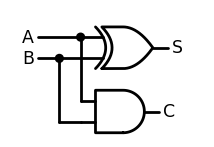

In [34]:
from schemdraw import logic, Drawing

d = Drawing(unit=.5)
d += (S := logic.Xor().label('S', 'right'))
d += (A := logic.Dot().at(S.in1))
d += logic.Line().left().length(d.unit*2).label('A', 'left')
d += logic.Line().left().at(S.in2)
d += (B := logic.Dot())
d += logic.Line().left().label('B', 'left')

d += logic.Line().down().at(A.start).length(d.unit*3)
d += (C := logic.And().right().anchor('in1').label('C', 'right'))
d += logic.Line().down().at(B.start).toy(C.in2)
d += logic.Line().to(C.in2)
d.draw()


---

【補足】半加算器  

「1ビットの数字」2つを足し算、繰り上がりを含めた計算ができない  
以下の4パターンのみ  
- 0 + 0 = 0  
- 0 + 1 = 1  
- 1 + 0 = 1  
- 1 + 1 = 10  


上記の図は  
S：XORにより、値が同じ場合は「0」 → 下1桁目の加算を表す  
- 0,0 → 0  
- 0,1 or 1,0 → 1  
- 1,1 → 10  


C：ANDにより、どちらも値が1の場合は「1」 → 下2桁目の繰り上がりを表す  
- 1,1 → 1  
- その他は0  


参考：全加算器は「1ビットの数字」2つを足し算、繰り上がりを含めた計算が可能  


---


## ニューラルネットワーク

前章までに説明した単回帰モデル、重回帰モデル、線形二値分類モデル、線形多クラス分類モデルはニューラルネットワークの特殊形と位置付けることができる。そこで、本節ではニューラルネットワークに関する一般的な説明を行う。用語や数式の説明が多くなるため退屈かもしれないが、いずれも重要な概念であるので、頭の片隅に留めておいて欲しい。


---

### 単層ニューラルネットワーク

**単層ニューラルネットワーク**（single-layer neural network）は次の一般的な式で表現される。


---

【ポイント】 単層ニューラルネットワーク  


<a id="f7-12"></a>
(7.12)  
$$
\begin{align}
\pmb{y} = g(\pmb{x}\pmb{W} + \pmb{b})
\end{align}
$$


---

ここで、

+ $d_{\rm in}$: 入力ベクトルの要素数
+ $d_{\rm out}$: 出力ベクトルの要素数
+ $\pmb{x} \in \mathbb{R}^{1 \times d_{\rm in}}$: 入力ベクトル（列ベクトルではなく行ベクトルであることに注意）
+ $\pmb{y} \in \mathbb{R}^{1 \times d_{\rm out}}$: 出力ベクトル（列ベクトルではなく行ベクトルであることに注意）
+ $\pmb{W} \in \mathbb{R}^{d_{\rm in} \times d_{\rm out}}$: 入力を出力に変換する行列（モデルのパラメータ）
+ $\pmb{b} \in \mathbb{R}^{1 \times d_{\rm out}}$: 出力ベクトルに関するバイアスベクトル（モデルのパラメータ）
+ $g: \mathbb{R} \longmapsto \mathbb{R}$: 活性化関数（引数がベクトルや行列のときは、要素ごとに活性化関数を適用する）

である。なお、これまでの章では、「ベクトル」は値が縦に並んだ列ベクトルを採用していたが、この章の以降では値が横に並んだ行ベクトルを採用する。


---

### 【補足】単層パーセプトロン  

単層のニューラルネットワークのことを単層パーセプトロン（SLP: single-layer perceptron）や単純パーセプトロン（simple perceptron）と同義のように呼ぶことがある。パーセプトロンは、活性化関数($g$)に「ステップ関数」を採用したニューラルネットワークの特殊形であり、パーセプトロンよりもニューラルネットワークの方が広い概念である。


【補足】の補足  
パーセプトロン：複数のシグナルを受け取り、1 つのシグナルを出力する  

![](./fig/perceptron.png)  


---

### 【補足】行ベクトル  

数学の教科書では列ベクトルを用いることが多いが、ニューラルネットワークの定式化では行ベクトルもよく用いられる。深層学習フレームワークなどで入力を行列や活性化関数などで変換する処理を記述するとき、左から右に処理内容を記述することが多い。例えば、PyTorchを用いる場合、式[(7.12)](#f7-12)は、

`y = x.mm(W).add(b).sigmoid()`

と記述できる。ベクトル$\pmb{x}$と行列$\pmb{W}$の積とバイアスベクトル$\pmb{b}$の加算を数式と同じ順番で記述できる。もし列ベクトルを用いて数式を記述する場合は、線形変換の行列を左側に配置することになる。


---

### 【補足】アフィン変換  

画像の拡大縮小・回転・平行移動など、行列を使って座標を変換すること。  
線形変換はアフィン変換の一部  

![](./fig/diff_affine.png)  


---

式[(7.12)](#f7-12)は、出力ベクトル$\pmb{y}$の$j$番目の要素の値$y_j$を計算する式としても表される。

<a id="f7-13"></a>
(7.13)  
\begin{align}
y_j = g\left(\sum_{i=1}^{d_{\rm in}} x_i W_{i,j} + b_j\right)
\end{align}

この式からも明らかなように、行列$\pmb{W}$の$i$行$j$列の要素$W_{i,j}$は入力値$x_i$から出力値$y_j$を計算するときの重み、ベクトル$\pmb{b}$の$j$番目の要素$b_j$は出力値$y_j$を計算するときのバイアスを表している。

入力$\pmb{x}$と行列$\pmb{W}$の積$\pmb{x}\pmb{W}$は、ベクトル$\pmb{x}$を行列$\pmb{W}$で**線形変換**（linear transformation）することを表す。これにバイアスベクトル$\pmb{b}$を加えた$\pmb{x}\pmb{W} + \pmb{b}$は、数学の世界では線形変換ではなく、厳密には**アフィン変換**（affine transformation）である。ただ、ニューラルネットワークの分野では（バイアスベクトルの加算も含めて）線形変換と呼ぶことがある。線形変換に用いる行列のサイズ$d_{\rm in} \times d_{\rm out}$やバイアスベクトルのサイズ$1 \times d_{\rm out}$は、入力と出力のベクトルの要素数$d_{\rm in}, d_{\rm out}$に合わせて決定する。

式[(7.12)](#f7-12)は一つの入力$\pmb{x}$に対して出力を計算する式であった。$B$個の入力$\pmb{x}_1, \dots, \pmb{x}_B$に対して、式[(7.12)](#f7-12)を同時に適用するときは、$B$個の入力ベクトルを縦に積んだ入力行列$\pmb{X} \in \mathbb{R}^{B \times d_{\rm in}}$を定義し、

<a id="f7-14"></a>
(7.14)  
\begin{align}
\pmb{X} = \begin{pmatrix}
\pmb{x}_1 \\
\dots \\
\pmb{x}_B
\end{pmatrix}
\end{align}


式[(7.12)](#f7-12)の入力ベクトル$\pmb{x}$の箇所を入力行列$\pmb{X}$に置き換えるだけでよい。

<a id="f7-15"></a>
(7.15)  
\begin{align}
\pmb{Y} = g(\pmb{X}\pmb{W} + \pmb{b})
\end{align}

このとき、出力もサイズ$d_{\rm out}$の実ベクトル$\pmb{y}$から$B \times d_{\rm out}$の実行列$\pmb{Y}$に拡張される。このように、複数の入力をまとめて処理することはミニバッチ処理と呼ばれる。ミニバッチ処理は、GPUなどのハードウェアでニューラルネットワークの計算を並列に実行するときによく用いられるテクニックである。

#### 活性化関数

入力を線形変換したのち、**活性化関数**（activation function）を通して出力が得られる。活性化関数により、出力を特定の値域に抑えたり、入力に対して非線形な出力を得ることができる。非線形な活性化関数としては、シグモイド関数$\sigma$の他、双曲線関数（$\tanh$）やReLU、ステップ関数などがよく用いられる。


---

【ポイント】 活性化関数  

<a id="f7-16"></a>
(7.16)  
\begin{align}
\tanh a = \frac{e^a - e^{-a}}{e^a + e^{-a}} = 2\sigma(2a) - 1 \\
\end{align}

<a id="f7-17"></a>
(7.17)  
\begin{align}
{\rm ReLU}(a) = \max(0, a)
\end{align}

<a id="f7-18"></a>
(7.18)  
\begin{align}
{\rm step}(a) = \begin{cases}
1 & (0 < a) \\
0 & (a \leq 0)
\end{cases}
\end{align}


---


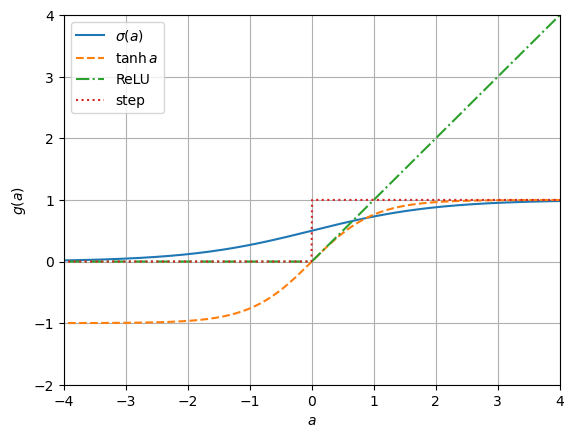

In [35]:
fig, ax = plt.subplots(dpi=100)
x = np.linspace(-5, 5, 1000)
ax.plot(x, 1 / (1 + np.exp(-x)), label='$\sigma(a)$', ls='-')
ax.plot(x, (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x)), label=r'$\tanh a$', ls='--')
ax.plot(x, np.maximum(x, 0), label='ReLU', ls='-.')
ax.plot(x, np.heaviside(x, 0), label='step', ls=':')
ax.set_xlabel('$a$')
ax.set_ylabel('$g(a)$')
ax.set_xlim(-4, 4)
ax.set_ylim(-2, 4)
ax.legend()
ax.grid()
plt.show()

双曲線関数はシグモイド関数と形状が似ているが、出力値の範囲が$(-1, 1)$となる。  


ReLUは入力値が負ならば$0$を出力し、正ならばその値を出力する活性化関数である。  
$0 < x$ならば微分値が常に$1$になるという特徴を持ち、多層のニューラルネットワークの学習でよく用いられる。  


ステップ関数は出力値が$0$または$1$であるので、線形二値分類モデルで出力ラベルを予測するときに用いられるが、$a \neq 0$において微分値が常に$0$となるためモデルの学習には用いられない。  


活性化関数にステップ関数を採用した単層ニューラルネットワークは、単層パーセプトロン（SLP: single-layer perceptron）や単純パーセプトロン（simple perceptron）と呼ばれる。  


なお、非線形な変換を省略する場合は、活性化関数として恒等写像$g(a) = a$を採用したと考えればよい。


---

#### 人工ニューラルネットワーク

式[(7.12)](#f7-12)  

$$
\begin{align}
\pmb{y} = g(\pmb{x}\pmb{W} + \pmb{b})
\end{align}
$$

は、以下のような図で表されることがある（$d_{\rm in} = 2$, $d_{\rm out} = 3$である）。

<img src="fig/slnn.svg" width="480px" />

ニューラルネットワークの起源は1943年にMcCullochとPittsが発表した論文と言われている。その論文の冒頭に、次のような記述がある。

> 神経系はニューロンのネットワークで、細胞体と軸索から構成されている。あるニューロンの軸索と別のニューロンの細胞体の間には、シナプスがある。ニューロンには閾値があり、パルスを出すには神経的興奮が閾値を超えなければならない。

先ほどの図において活性化関数にステップ関数を用いると、ニューロンの活性値（活動電位）が$x_i$や$y_j$に、あるニューロンと別のニューロンを結ぶ軸索の重みが$W_{i,j}$に、閾値を調整するパラメータが$b_j$に対応する。入力や出力の一つの変数を一つのニューロンに対応付け、その間をつなぐネットワークを人工的に模擬しているので、**人工ニューラルネットワーク**（artificial neural network）とも呼ばれる。入力や出力のベクトル$\pmb{x}, \pmb{y}$は、複数の人工ニューロンの活性値をまとめて表現したものと考えればよい。なお、McCullochとPittsの論文で論じられていたニューラルネットワークモデルは閾値論理ユニット（threshold logic unit）と呼ばれる。

#### 単回帰、重回帰、線形二値分類、線形多クラス分類との関連

これまでに説明した単回帰モデル、重回帰モデル、線形二値分類モデル、線形多クラス分類モデルは、式[(7.12)](#f7-12)を以下のように特殊化したものである。

+ 単回帰: $d_{\rm in} = d_{\rm out}=1$、$g$は恒等写像 → 自分自身を返す、結果をそのまま返却  
+ 重回帰: $d_{\rm in} > 1$, $d_{\rm out}=1$、$g$は恒等写像
+ 線形二値分類（ロジスティック回帰）: $d_{\rm out}=1$, $g$はステップ関数（予測時） → 0か1を返却
+ 線形多クラス分類（多クラスロジスティック回帰）: $d_{\rm out}$は分類のクラス数, $g$は${\rm argmax}$関数（予測時）→ $n$個返却  

異なるタスクを解くモデルに対して統一的な定式化や学習方法を見出すことができることは、ニューラルネットワークの魅力の一つである。


---

#### 【補足】誤差と残差  

回帰を説明していた章では、誤差と残差を混同しないように配慮していたが、ニューラルネットワークの世界では「誤差」を使う方が一般的であるため、ここでは二乗誤差や平均二乗誤差という用語を用いる。


---

#### 【補足】損失関数とは  

「予測値」と「正解値」の誤差を計算するための関数  


---

#### 【補足】クロス(交差)エントロピーとは  

エントロピーとは、状態のバラつき具合を表すもの  


クロスエントロピーは損失関数の一つで、分類(1 or 0)問題を扱う場合に使用される  
2つの確率に対する近似性を表す(2つの確率をクロス) → 近いほど数字が小さくなる  
- $y$ ： `1` or `0` → 正解の確率：`100%` or `0%`  
- $\hat{y}$ ： 上記の値が正しいかを予測する確率 `xx%`  


![](./fig/cross_entropy.png)  


- E：誤差  
- p(k)：正解率  


例）教師データは正解：1(100%）だが、その値が正しいかを予測する確率は10%の場合  
2つの確率が乖離しているため、誤差Eが大きくなる  
→ 正解は0の可能性が高い  


---

#### 損失関数

単層ニューラルネットワークのパラメータ、すなわち式[(7.12)](#f7-12)の行列$\pmb{W}$とベクトル$\pmb{b}$を教師有り学習で推定するには、訓練事例の目的値（正解）とモデルの予測値の間に損失関数（loss function）を定義し、訓練データ全体の損失値を最小にするパラメータを確率的勾配降下法で求めるのが一般的である。確率的勾配降下法により損失関数を最小化する方法は、単回帰モデル、重回帰モデル、線形二値分類モデル、線形多クラス分類モデルに対して詳説した通りである。用いる損失関数もこれまでに説明した通りであるが、以下にまとめる。


単回帰モデルや重回帰モデルの学習に最もよく用いられる損失関数は、**二乗誤差**（squared error）である。ある訓練事例において、目的値（正解）を$y \in \mathbb{R}$、モデルの予測値を$\hat{y} \in \mathbb{R}$と書くことにすると、その訓練事例における二乗誤差は、


---

【ポイント】 二乗誤差  

<a id="f7-19"></a>
(7.19)  
$$
\begin{align}
l_{\rm MSE}(y, \hat{y}) = (y - \hat{y})^2
\end{align}
$$


---

式[(7.19)](#f7-19)は式[(4.31)](#f4-31)と等価である。訓練データ全体やミニバッチごとに二乗誤差の平均をとったものは**平均二乗誤差**（MSE: Mean Squared Error）と呼ばれる。

二値分類モデルの学習に最もよく用いられる損失関数は、**二値クロスエントロピー**（binary cross entropy）である。ある訓練事例において、正解の二値ラベルを$y \in \{0, 1\}$、モデルがラベルを$1$と予測する確率推定値を$\hat{y}$と書くことにすると、その訓練事例における二値クロスエントロピーは、


---

【ポイント】 二値クロスエントロピー  

<a id="f7-20"></a>
(7.20)  
$$
\begin{align}
l_{\rm BCE}(y, \hat{y}) = - y \log \hat{y} - (1-y)\log(1-\hat{y})
\end{align}
$$


---

線形二値分類の章では、モデルが予測した二値ラベルを$\hat{y} \in \{0, 1\}$と定義しており、ラベルを$1$と予測する確率推定値を$p$で表していた。その定義の差を吸収し、損失は負の対数尤度で定義されることを考慮すれば、式[(7.20)](#f7-20)と式[(5.27)](#f5-27)は等価である。

多クラス分類モデルの学習に最もよく用いられる損失関数は、**クロスエントロピー**（cross entropy）である。ある訓練事例において、正解のラベルを1-of-$K$表現$\pmb{y} \in \{0, 1\}^{K}$（ただし、$K = d_{\rm out}$は分類するクラスの数）、モデルがラベルを予測する確率分布を$\hat{\pmb{y}} \in [0, 1]^K$と書くことにすると、その訓練事例におけるクロスエントロピーは、


---

【ポイント】 クロスエントロピー  

<a id="f7-21"></a>
(7.21)  
$$
\begin{align}
l_{\rm CE}(\pmb{y}, \hat{\pmb{y}}) = - \sum_{k=1}^{K} y_k \log \hat{y}_k
\end{align}
$$


---

線形多クラス分類の章では、$\hat{y} \in \{1, 2, \dots, K\}$をモデルが予測したラベルと定義しており、モデルがラベルを予測する確率分布を$\pmb{p} \in [0, 1]^K$で表していた。その定義の差を吸収し、損失は負の対数尤度で定義されることを考慮すれば、式[(7.21)](#f7-21)と式[(6.31)](#f6-31)は等価である。

二値分類モデルおよび多値分類モデルの損失関数がクロスエントロピー（交差エントロピー）と呼ばれる理由を補足しておく。クロスエントロピーは2つの確率分布$p(x)$と$q(x)$の近さを測定する指標で、次式で定義される。

<a id="f7-22"></a>
(7.22)  
\begin{align}
H(p, q) = -\sum_{x} p(x) \log q(x)
\end{align}

分類モデルの定式化では、$p(x)$は真のラベルの確率分布、$q(x)$はモデルが予測したラベルの確率分布と考えればよい。$K$クラス分類の場合、その2つの確率分布のクロスエントロピーは、

<a id="f7-23"></a>
(7.23)  
\begin{align}
H(p, q) = -\sum_{k=1}^K p(k) \log q(k)
\end{align}

であり、これは式[(7.20)](#f7-20)や式[(7.21)](#f7-21)と整合する。


---


### 多層ニューラルネットワーク

[「閾値論理ユニット」](#f7-0)の節では、XORの入出力を再現するために、ある線形二値分類器の出力を別の線形二値分類器の入力に接続した。線形二値分類器は単層ニューラルネットワークの一種であるので、ある単層ニューラルネットワークの出力を別の単層ニューラルネットワークの入力に接続し、二つのニューラルネットワークを連結したことになる。このように、複数の単層ニューラルネットワークを連結して構成されたニューラルネットワークを**多層ニューラルネットワーク**と呼ぶ。例えば、2次元のベクトルを入力として受け取り、第1層で2次元のベクトルに変換し、第2層で1次元の値に変換する多層ニューラルネットワークは次式で記述される。

<a id="f7-24"></a>
(7.24)  
$$
\begin{align}
\pmb{h} &= g^{(1)}(\pmb{x}\pmb{W}^{(1)} + \pmb{b}^{(1)}) \\
y &= g^{(2)}(\pmb{h}\pmb{W}^{(2)} + b^{(2)}) \\
\end{align}
$$

ここで、

+ $\pmb{x} \in \mathbb{R}^{1 \times 2}$: 第1層に与える入力ベクトル
+ $\pmb{h} \in \mathbb{R}^{1 \times 2}$: 第1層の出力ベクトル（＝第2層の入力ベクトル）
+ $y \in \mathbb{R}$: 第2層から出力されるベクトル（要素数が$1$なので実数値）
+ $\pmb{W}^{(1)} \in \mathbb{R}^{2 \times 2}$: 第1層の変換行列（モデルのパラメータ）
+ $\pmb{b}^{(1)} \in \mathbb{R}^{1 \times 2}$: 第1層のバイアスベクトル（モデルのパラメータ）
+ $g^{(1)}$: 第1層の活性化関数
+ $\pmb{W}^{(2)} \in \mathbb{R}^{2 \times 1}$: 第2層の変換行列（実際には列ベクトル）（モデルのパラメータ）
+ $b^{(2)} \in \mathbb{R}$: 第2層のバイアス（モデルのパラメータ）
+ $g^{(2)}$: 第2層の活性化関数

である。このニューラルネットワークを図示したものを示す（バイアスは省略した）。

<img src="fig/mlnn.svg" width="720px" />

ここに示した例は、2個の入力$x_1, x_2$から2個の中間的な値$h_1, h_2$を作り、その中間的な値から1個の値$y$を出力するニューラルネットワークである。1層目の入力をサイズ$2$のベクトル$\pmb{x} = \begin{pmatrix}x_1 & x_2\end{pmatrix}$で表し、出力をサイズ$2$のベクトル$\pmb{h} = \begin{pmatrix}h_1 & h_2\end{pmatrix}$で表すことにすると、1層目はサイズ$2$のベクトルからサイズ$2$のベクトルへの写像と考えられる。この写像は、$2 \times 2$の線形変換行列$\pmb{W}^{(1)}$と、サイズ$2$のバイアスベクトル$\pmb{b}^{(1)}$、活性化関数$g^{(1)}$で構成される。この第1層のように、入力に一番近い層を**入力層**と呼ぶ。続いて、2層目はサイズ$2$のベクトルからサイズ$1$のベクトル（スカラー）への写像と考えられる。この写像は、$2 \times 1$の線形変換行列（ベクトル）$\pmb{W}^{(2)}$と、バイアス$b^{(2)}$、活性化関数$g^{(2)}$で構成される。この第2層のように、出力に一番近い層を**出力層**と呼ぶ。なお、ベクトル$\pmb{h}$は、入力や出力として直接与えるものではなく、中間的に計算されるものであるため、**中間層**、**隠れ状態ベクトル**、**隠れ層**、隠れユニットなどと呼ばれる。

ニューラルネットワークの層数の数え方には若干の混乱がある。$\pmb{x}, \pmb{h}, y$を層として数えることにして、先ほどのニューラルネットワークを$3$層と数えることもある。しかし、この資料では入力$\pmb{x}$はカウントしないことにして、このニューラルネットワークを$2$層と数える。これは、写像の数やパラメータ・セットの数である$2$に一致する。また、出力層から数えたネットワークの深さ$2$とも一致する。

一般的に、$L$層のニューラルネットワークの第$l \in \{1, \dots, L\}$層の写像$f^{(l)}$で表すことにする。入力$\pmb{x}$に対して$L$層のニューラルネットワークを通して得られた出力$\pmb{y}$は、

<a id="f7-25"></a>
(7.25)  
\begin{align}
\pmb{y} = f^{(L)}\left(f^{(L-1)}\left( \dots \left(f^{(1)}(\pmb{x})\right) \dots \right)\right)
\end{align}

と表すことができる。$l$層目の写像$f^{(l)}$は次式で表すことができる。


---

【ポイント】 多層ニューラルネットワーク  

<a id="f7-26"></a>
(7.26)  
$$
\begin{align}
\pmb{h}^{(l)} &= f^{(l)}(\pmb{h}^{(l-1)}) = g^{(l)}(\pmb{h}^{(l-1)}\pmb{W}^{(l)} + \pmb{b}^{(l)})
\end{align}
$$


---

ここで、

+ $\pmb{h}^{(l-1)}$: 第$l-1$層のベクトル（第$l$層への入力）
+ $\pmb{h}^{(l)}$: 第$l$層のベクトル（第$l$層からの出力）
+ $\pmb{W}^{(l)}$: 第$l$層の変換行列（モデルのパラメータ）
+ $\pmb{b}^{(l)}$: 第$l$層のバイアスベクトル（モデルのパラメータ）
+ $g^{(l)}$: 第$l$層の活性化関数

である。また、$\pmb{h}^{(0)} = \pmb{x}, \pmb{h}^{(L)} = \pmb{y}$と定義する。この表記法に従って3層のニューラルネットワークを図示した例を以下に示す（バイアスは省略した）。

<img src="fig/mlnn-general.svg" width="800px" />

これまで紹介したニューラルネットワークのように、入力と出力の間にループが存在しないニューラルネットワークを**順伝搬型ニューラルネットワーク**（feedforward neural network）と呼ぶ。

#### XORを実現する2層のニューラルネットワークの構成例

多層ニューラルネットワークの一般的な表現方法を説明したので、XORの入出力を再現する2層のニューラルネットワークを実際に表現してみよう。2つの入力$\pmb{x} = \begin{pmatrix}x_1 & x_2\end{pmatrix} \in \{0, 1\}^2$を受け取り、中間層$\pmb{h} = \begin{pmatrix}h_1 & h_2\end{pmatrix} \in \{0, 1\}^2$を介して1つの出力$y \in \{0, 1\}$を得る2層のニューラルネットワークは次式で表現できる。

<a id="f7-27"></a>
(7.27)  
$$
\begin{align}
\pmb{h} &= {\rm step}(\pmb{x}\pmb{W}^{(1)} + \pmb{b}^{(1)}) \\
y &= {\rm step}(\pmb{h}\pmb{W}^{(2)} + b^{(2)}) \\
\end{align}
$$

[「閾値論理ユニット」](#f7-0)の節では、入力に対してORとNANDを取った出力に対して、ANDを取ることでXORの入出力を実現できることを説明した。$h_1$を$x_1, x_2$の論理和（OR）、$h_2$を$x_1, x_2$の否定論理積（NAND）とすると、$y$は$h_1, h_2$の論理積（AND）とすればよい。これらの論理結合子を実現するパラメータは無数にあるが、ここでは次式で表すことにする。

<a id="f7-28"></a>
(7.28)  
\begin{align}
h_1 &= x_1 \vee x_2 = {\rm step}(x_1 + x_2 - 0.5) \\
h_2 &= \lnot (x_1 \wedge x_2) = {\rm step}(-x_1 - x_2 + 1.5) \\
y &= h_1 \wedge h_2 = {\rm step}(h_1 + h_2 - 1.5)
\end{align}


---

【補足】  

$x_1$ = [0,0,1,1]  
$x_2$ = [0,1,0,1]  


$h_1$ = $x_1$ or $x_2$ = [0,1,1,1]  
$h_2$ = ￢($x_1$ and $x_2$) = [1,1,1,0]  


$h_1$ and $h_2$ = [0,1,1,0]  


step(a) 関数：numpyの`heaviside()` を使用  
- a > 0 →  1  
- a = 0 →  0  
- a < 0 →  0  


h1 = [ step(-0.5), step(0.5), step(0.5), step(1.5) ] = [0,1,1,1]  
h2 = [ step(1.5), step(0.5), step(0.5), step(-0.5) ] = [1,1,1,0]  


y = [ step(-0.5), step(0.5), step(0.5), step(-0.5) ] = [0,1,1,0]  


---


ここから、1層目と2層目のニューラルネットワークのパラメータを抽出すると、

<a id="f7-29"></a>
(7.29)  
\begin{align}
W^{(1)}_{1,1} &= 1 \\
W^{(1)}_{2,1} &= 1 \\
b^{(1)}_1 &= -0.5 \\
W^{(1)}_{1,2} &= -1 \\
W^{(1)}_{2,2} &= -1 \\
b^{(1)}_2 &= 1.5 \\
W^{(2)}_{1,1} &= 1 \\
W^{(2)}_{2,1} &= 1 \\
b^{(2)} &= -1.5 \\
\end{align}


ゆえに、式[(7.27)](#f7-27)のパラメータを次のようにセットすればよい。

<a id="f7-30"></a>
(7.30)  
\begin{align}
\pmb{W}^{(1)} &= \begin{pmatrix}
W^{(1)}_{1,1} & W^{(1)}_{1,2} \\
W^{(1)}_{2,1} & W^{(1)}_{2,2}
\end{pmatrix} = \begin{pmatrix}
1 & -1 \\
1 & -1
\end{pmatrix} \\
\pmb{b}^{(1)} &= \begin{pmatrix}
b^{(1)}_1 & b^{(1)}_2
\end{pmatrix} = \begin{pmatrix}
-0.5 & 1.5
\end{pmatrix} \\
\pmb{W}^{(2)} &= \begin{pmatrix}
W^{(2)}_{1,1} \\
W^{(2)}_{2,1}
\end{pmatrix} = \begin{pmatrix}
1 \\
1
\end{pmatrix} \\
b^{(2)} &= -1.5
\end{align}

では、実際にプログラムとして実装して動作を確認してみよう。パラメータの行列とベクトルをそのまま変数として定義する。


In [36]:
w_xh = np.array([
    [1, -1],
    [1, -1]
])
b_xh = np.array([-0.5, 1.5])
w_hy = np.array([
    1,
    1
])
b_hy = np.array([-1.5])

まず、入力として$x_1 = x_2 = 1$を考える。入力ベクトル$\pmb{x} = \begin{pmatrix}1 & 1\end{pmatrix}$を変数`x`で表す。

In [37]:
x = np.array([1, 1])

中間層のベクトル$\pmb{h}$を計算するプログラムを式[(7.27)](#f7-27)に従って実装する。$h_1$に入力の論理和（OR）、$h_2$に入力の否定論理積（NAND）が計算されていることが確認できる。

In [38]:
x @ w_xh + b_xh

array([ 1.5, -0.5])

In [39]:
h = np.heaviside(x @ w_xh + b_xh, 0)
h

array([1., 0.])

続けて、出力$y$を計算するプログラムを式[(7.27)](#f7-27)に従って実装する。入力ベクトルのXORを計算した結果である$0$が得られる。

In [40]:
h @ w_hy + b_hy

array([-0.5])

In [41]:
y = np.heaviside(h @ w_hy + b_hy, 0)
y

array([0.])

先ほどは一つの入力の組に対して計算する例であったが、ミニバッチ化の考え方に基づき、ほぼ同じプログラムで複数の入力の組に対する結果を得ることができる。4通りのすべての入力の組を与えるため、入力ベクトルを縦方向に拡張した行列を変数`x`で表す。

In [42]:
x = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

中間層を計算するプログラムを変更することなく、4通りの入力に対する出力（ORとNANDの出力）を得ることができる。

In [43]:
x @ w_xh + b_xh

array([[-0.5,  1.5],
       [ 0.5,  0.5],
       [ 0.5,  0.5],
       [ 1.5, -0.5]])

In [44]:
h = np.heaviside(x @ w_xh + b_xh, 0)
h

array([[0., 1.],
       [1., 1.],
       [1., 1.],
       [1., 0.]])

出力を計算するプログラムも変更しなくてよい。4通りの入力に対するXORの結果を得ることができた。

In [45]:
h @ w_hy + b_hy

array([-0.5,  0.5,  0.5, -0.5])

In [46]:
y = np.heaviside(h @ w_hy + b_hy, 0)
y

array([0., 1., 1., 0.])

## 万能近似定理

**万能近似定理**（Universal Approximation Theorem、普遍性定理とも訳される）は、１層の隠れ層を持つニューラルネットワーク（２層のニューラルネットワーク）は、いかなる連続関数も近似的に表現する能力があることを示した。  

---

【補足】  
これまでの説明 = 万能近似定理 の一例  
- 数値情報であれば何でも近似できる  
- 理論的には、データ・素子数が無限にあるニューラルネットワークを用いることで、どのような問題でも学習できる  
  → 入力を複数にすることで、グラフ線の傾きを変えられる  

![](./fig/UAT.png)  


万能近似定理によって、なぜ上手く動作するのか？理由を数式で証明  
- 不可思議な挙動ではない  
- 仮説でもない  
- 説明責任を果たせる  


以降は、万能近似定理の数式で用いられているパラメータの値を変えることで、グラフ線の傾きを変えられる(近似できる)ことを説明  
ただし近似させることは可能だが、過学習になるリスクあり  


---

ここで、$d$次元ベクトル$\pmb{x} \in \mathbb{R}^d$を入力として実数を出力する２層のニューラルネットワーク$F(\pmb{x})$を、正の整数$M$、実定数$v_i, b_i \in \mathbb{R}$、実ベクトル$\pmb{w}_i \in \mathbb{R}^d$を用いて、以下の式で表す。
\begin{align*}
F(\pmb{x}) = \sum_{i=1}^M v_i \sigma(\pmb{w}_i^\top \pmb{x} + b_i) \\
\end{align*}
すなわち、ニューラルネットワークの１層目は$\pmb{w}_i, b_i$ ($i \in \{1, \dots, M\}$) をパラメータ、シグモイド関数$\sigma$を活性化関数として用い、２層目は$v_i$ ($i \in \{1, \dots, M\}$) をパラメータとして用いている。


近似的に表現したい連続関数を$f(\pmb{x})$とすると、任意の定数$\epsilon > 0$に関して、
\begin{align*}
|F(\pmb{x}) - f(\pmb{x})| < \epsilon
\end{align*}
を満たすように、$M, v_i, b_i, \pmb{w}_i$が存在することを証明したのが、万能近似定理である。

ここでは、この定理の厳密な証明は行わず、$d=1$の場合において１層の隠れ層を持つニューラルネットワークがどのように連続関数を近似するのか説明する。なお、この説明では Nielsen[[2019](https://chokkan.github.io/mlnote/reference.html#id8)] を参考にした。

$F(x)$は次式で表される。
\begin{align*}
F(x) = \sum_{i=1}^M v_i \sigma(w_i x + b_i) \\
\end{align*}

パラメータ$M, v_i, w_i, b_i$の役割を調べるため、$F(x)$をPythonの関数として実装する。後で軌跡を描画するときに都合がよいため、引数`x`にベクトルが与えられた場合は、その各要素に対して$F(x)$を適用した結果をベクトルとして返すように実装した。

In [47]:
def f(x, v, w, b):
    def sigmoid(x):  
        return np.exp(-np.logaddexp(0, -x))
    return np.dot(sigmoid(np.outer(x, w) + b), v)

### $w$を動かす

まず、$M=1, v_1 = 1, b_1 = 0$とおく。
\begin{align*}
F(x) = \sigma(w x) \\
\end{align*}
である。そして、$w$を$2^{-8} \leq w \leq 2^{8}$の範囲で動かしたときに$F(x)$がどのようになるのか観察する。

In [48]:
def init_graph(xmin, xmax, ymin, ymax):
    fig, ax = plt.subplots(dpi=150)
    ax.set_xlim(xmin, xmax)
    ax.set_xticks(range(xmin, xmax+1, 2))
    ax.set_xticks(range(xmin, xmax+1, 1), minor=True)
    ax.set_ylim(ymin, ymax)
    ax.grid()
    return fig, ax

xmin, xmax = -10, 10
X = np.linspace(xmin, xmax, 1000)

In [49]:
v = np.array([1.])
b = np.array([0.])
WP = np.arange(-8, 9)

fig, ax = init_graph(xmin, xmax, -0.5, 1.5)

A = []
for wp in WP:
    artists = []
    artists += ax.plot(X, f(X, v, 2. ** wp, b), color='tab:blue')
    artists.append(ax.text(0, -0.4, f'$w = 2^{{ {wp} }}$', ha='center'))
    A.append(artists)

ani = matplotlib.animation.ArtistAnimation(fig, A, interval=200)
html = ani.to_jshtml()
plt.close(fig)
HTML(html)

関数の形はシグモイド関数そのものであるが、$w$が大きくなるほど、$x = 0$における変化が急峻となり、ステップ関数に近づいていくことが分かる。

### $b$を動かす

続いて、$M=1, v_1 = 1, w_1 = 1$とおく。すなわち、
\begin{align*}
F(x) = \sigma(x + b) \\
\end{align*}
である。そして、$b$を動かしたときに$F(x)$がどのようになるのか観察する。

In [50]:
v = np.array([1.])
B = np.arange(-8, 9)
w = np.array([1.])

fig, ax = init_graph(xmin, xmax, -0.5, 1.5)

A = []
for b in B:
    artists = []
    artists += ax.plot(X, f(X, v, w, b), color='tab:blue')
    artists.append(ax.axvline(-b, ls=':'))
    artists.append(ax.text(0, -0.4, f'$b = {b}$', ha='center'))
    A.append(artists)

ani = matplotlib.animation.ArtistAnimation(fig, A, interval=200)
html = ani.to_jshtml()
plt.close(fig)
HTML(html)

$y$軸の値が$0.5$になる点が$x = -b$となることが分かる。一般に、$F(x)$が以下の形であるとき、
\begin{align*}
F(x) = \sigma(w x + b)
\end{align*}
ある$x$軸上の点$x_0$において$F(x_0)=0.5$となる$b$は、
\begin{align*}
w x_0 + b &= 0 \\
b &= - w x_0
\end{align*}
と求めることができる。

### $v$を動かす

最後に、$M=1, w_1 = 1, b_1 = 0$に固定する。すなわち、
\begin{align*}
F(x) = v \sigma(x) \\
\end{align*}
として、$v$を動かしたときに$F(x)$がどのようになるのか観察する。

In [51]:
b = 0.
w = 1.
v = 1.
V = np.arange(-8., 8)

ymin, ymax = -10, 10
fig, ax = init_graph(xmin, xmax, ymin, ymax)
ax.set_yticks(range(ymin, ymax+1, 2))
ax.set_yticks(range(ymin, ymax+1, 1), minor=True)

A = []
for v in V:
    artists = []
    artists += ax.plot(X, f(X, v, w, b), color='tab:blue')
    artists.append(ax.text(0, -9, f'$v = {v}$', ha='center'))
    A.append(artists)

ani = matplotlib.animation.ArtistAnimation(fig, A, interval=200)
html = ani.to_jshtml()
plt.close(fig)
HTML(html)

シグモイド関数の出力を$v$倍した出力が得られている。

### 矩形の合成

さて、$w = 1000$に固定して、$v = 1, b=-1000$および$v = -1, b=-2000$に設定したときの$F(x)$の軌跡を描画する。

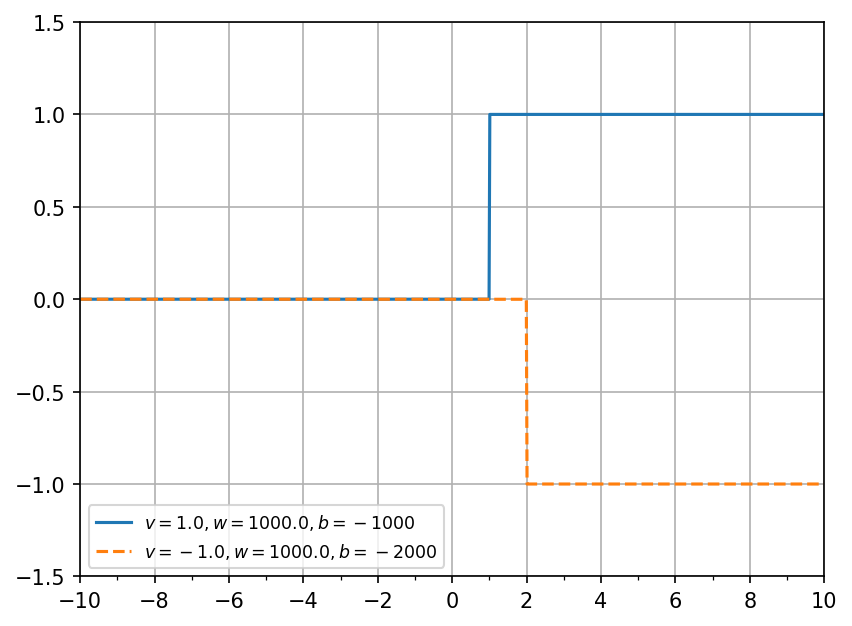

In [52]:
params = [
    # v, w, b, ls
    [1., 1000., -1000, '-'],
    [-1., 1000., -2000, '--'],
]

fig, ax = init_graph(xmin, xmax, -1.5, 1.5)
for v, w, b, ls in params:
    ax.plot(X, f(X, v, w, b), ls=ls, label=f'$v = {v}, w = {w}, b = {b}$')
ax.legend(fontsize='small', loc='lower left')
plt.show()

この2つの軌跡に関して、$y$軸の値を足し合わせると、$1 \leq x \leq 2$の範囲で矩形が現れることが想像される。これは、以下のモデルにおいて、
\begin{align*}
F(x) = \sum_{i=1}^M v_i \sigma(w_i x + b_i) \\
\end{align*}
$M=2, (v_1, w_1, b_1) = (1, 1000, -1000), (v_2, w_2, b_2) = (-1, 1000, -2000)$に設定したことに相当する。

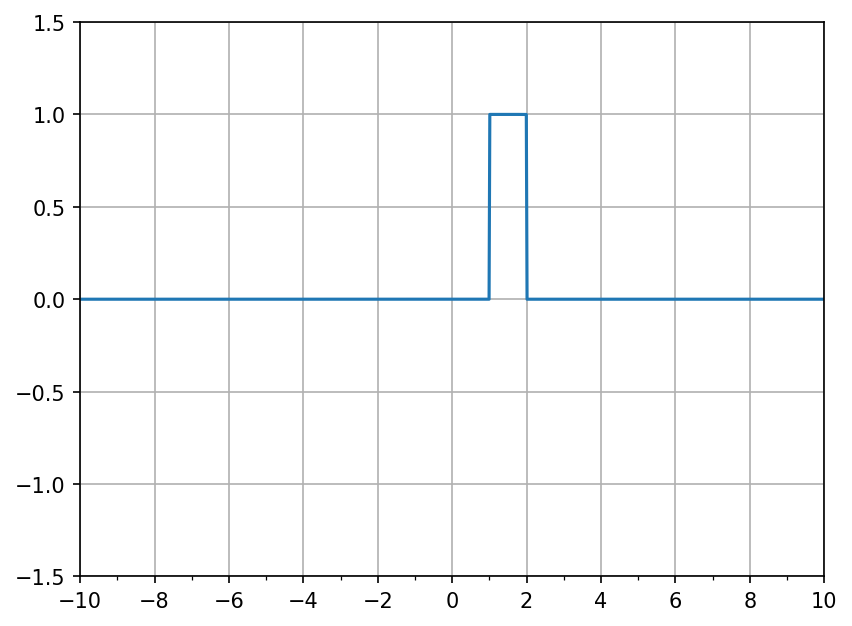

In [53]:
v = np.array([1, -1])
w = np.array([1000, 1000])
b = np.array([-1000, -2000])

fig, ax = init_graph(xmin, xmax, -1.5, 1.5)
ax.plot(X, f(X, v, w, b))
plt.show()

矩形の幅は$b_1$もしくは$b_2$を調整することで変更できる。

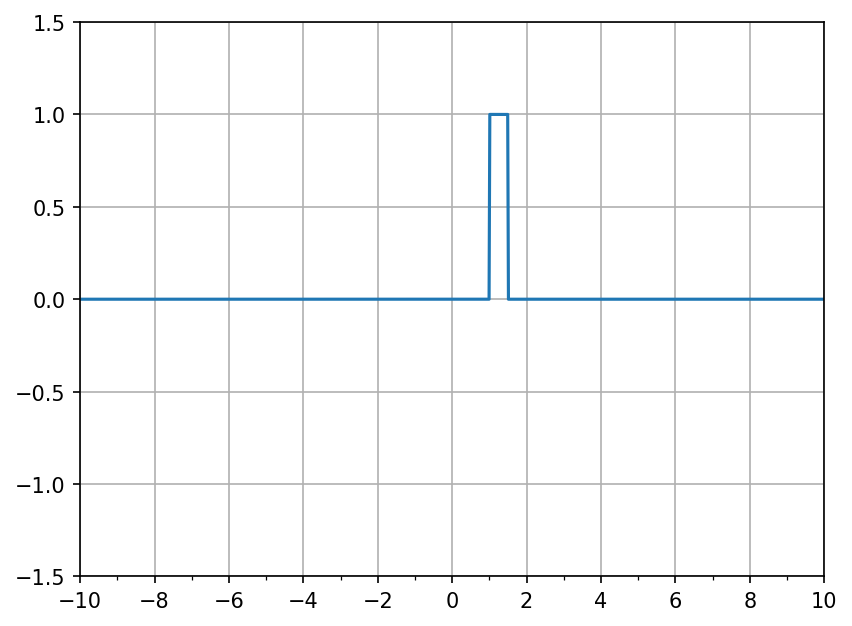

In [54]:
v = np.array([1, -1])
w = np.array([1000, 1000])
b = np.array([-1000, -1500])

fig, ax = init_graph(xmin, xmax, -1.5, 1.5)
ax.plot(X, f(X, v, w, b))
plt.show()

矩形の高さは$v$の値を調整することで変更できる（以下の例では$b_i$の値も変更してある）。

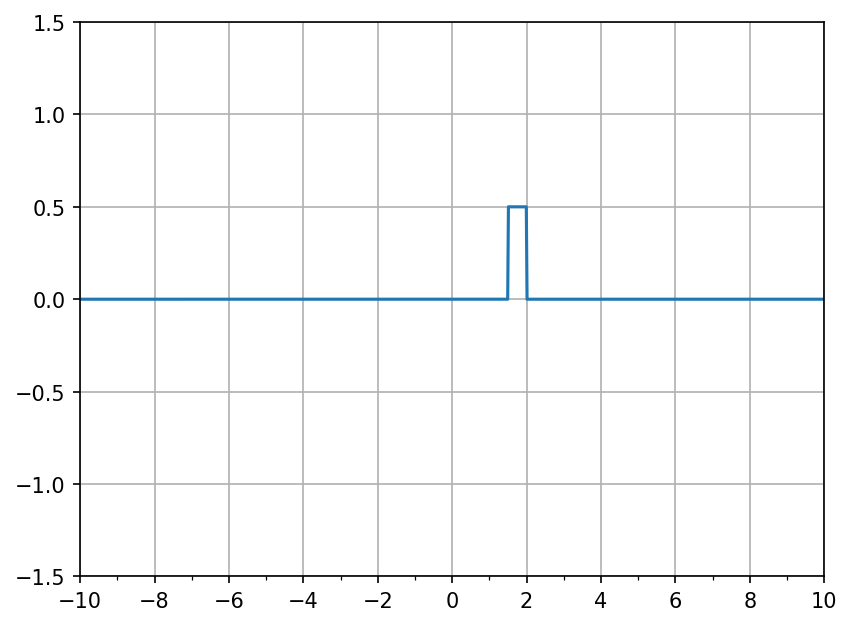

In [55]:
v = np.array([0.5, -0.5])
w = np.array([1000, 1000])
b = np.array([-1500, -2000])

fig, ax = init_graph(xmin, xmax, -1.5, 1.5)
ax.plot(X, f(X, v, w, b))
plt.show()

上の2つの矩形を組み合わせることもできる。

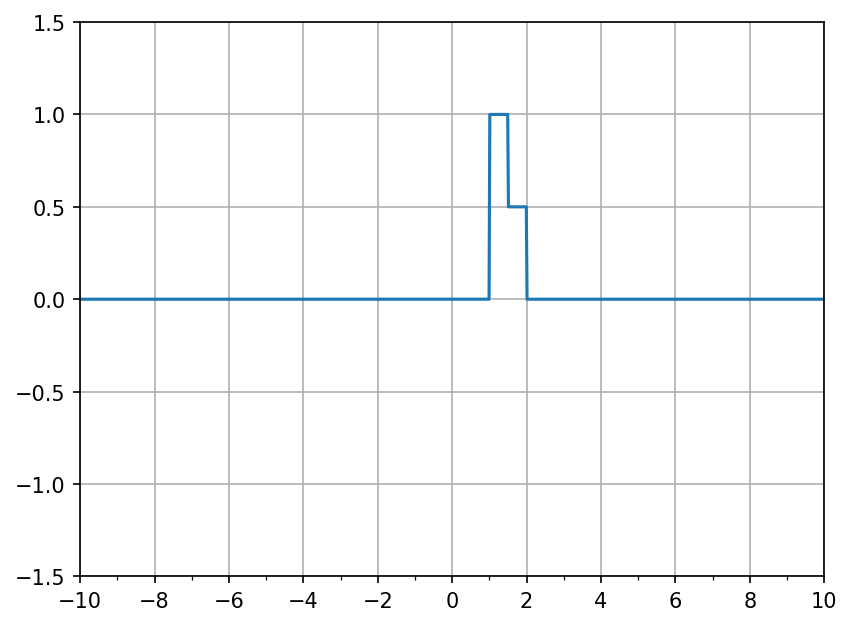

In [56]:
v = np.array([1, -1, 0.5, -0.5])
w = np.array([1000, 1000, 1000, 1000])
b = np.array([-1000, -1500, -1500, -2000])

fig, ax = init_graph(xmin, xmax, -1.5, 1.5)
ax.plot(X, f(X, v, w, b))
plt.show()

このように、表現したい関数$f(x)$を矩形の羅列として表現していくことで、関数$f(x)$を近似的に表現できる。

ただし、万能近似定理でニューラルネットワークがあらゆる関数を近似できたとしても、データから汎化性能の高いモデルを学習できるかどうかは別の話である。通常の学習データでは説明変数や目的変数の離散値しか得られないため、その間をうまく繋ぎ、モデルの汎化性能を高める必要があるが、万能近似定理はその点について何も保障しない。

## 確認問題

以下のセルで定義された関数`G`がある。

In [57]:
def G(x):
    if -5 <= x < 4:
        i = int(x + 5)
        return [-1, 0, 1, 0, -1, 1, 0, 1, -1][i]
    else:
        return 0

この関数の形状は以下の通りである。なお、[np.vectorize](https://numpy.org/doc/stable/reference/generated/numpy.vectorize.html)は関数`G`の引数にnumpy.arrayを渡し、その計算結果をnumpy.arrayでまとめて受け取れるようにするための「おまじない」である。

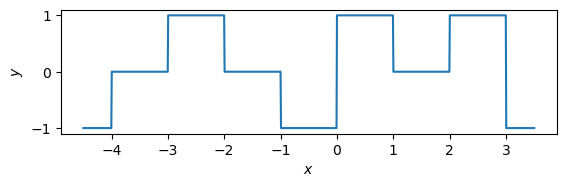

In [58]:
def plot(ax, f):
    X = np.linspace(-4.5, 3.5, 1000)
    Y = f(X)
    
    ax.plot(X, Y, '-')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_aspect('equal')

fig, ax = plt.subplots()
g = np.vectorize(G)
plot(ax, g)
plt.show()

さて、１層の隠れ層を持つニューラルネットワーク

\begin{align*}
F(x) = \sum_{i=1}^M v_i \sigma(w_i x + b_i) \\
\end{align*}

を考える。ここで、$M$は隠れ層のユニット数、$\pmb{v}, \pmb{w}, \pmb{b} \in \mathbb{R}^M$はモデルのパラメータである。$M$の値を適当に決定し、関数`G`の出力を再現するパラメータ$\pmb{v}, \pmb{w}, \pmb{b}$を求め、このニューラルネットワークの出力$F(x)$をプロットせよ。


---

まず、Fを定義・動作確認します。  

In [59]:
def F(x, v, w, b):
    def sigmoid(x):  
        return np.exp(-np.logaddexp(0, -x))
    return np.dot(sigmoid(np.outer(x, w) + b), v)

<AxesSubplot:>

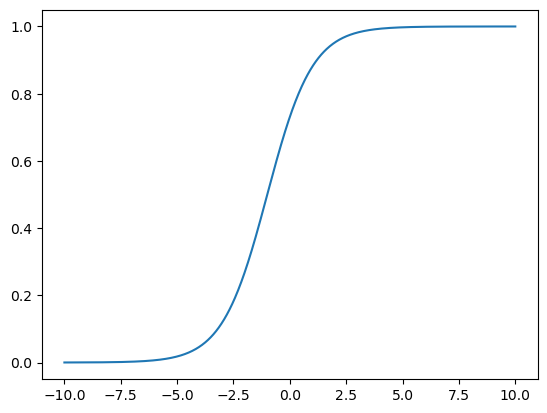

In [60]:
import pandas as pd


X = np.linspace(-10, 10, 1000)
pd.Series(F(X, np.array([1]), np.array([1]), np.array([1])), index=X).plot.line()

Gを再現するFのパラメーターを求めていきます。まず、$w$を固定します。Gは-1, 0, 1の整数値を取ります。Fの値に近づけるには、sigmoid関数に渡す値を大きくして値を1/-1に近くする必要があります。

In [61]:
w = 1e+6

$b$: Gの値が変化するxをもとに、矩形の変化する位置を設定します。

In [62]:
B = [5, 4, 3, 2, 1, 0, -1, -2, -3]
B = np.array(B) * w

$v$: Gの値の変化方向をもとに、矩形の変化方向と大きさを設定します。

In [63]:
V = [-1, 1, 1, -1, -1, 2, -1, 1, -2]

In [64]:
X = np.linspace(-4.5, 3.5, 1000)

<AxesSubplot:>

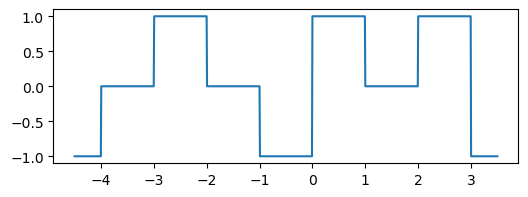

In [65]:
pd.Series(F(X, V, w, B), index=X).plot.line(figsize=(6, 2))

Gの値が再現できていることを確認します。

In [66]:
np.testing.assert_allclose(F(X, V, w, B), [G(x) for x in X])

---

[機械学習帳](https://chokkan.github.io/mlnote/) © Copyright 2020-2022 by [岡崎 直観 (Naoaki Okazaki)](https://www.chokkan.org/). この作品は<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">クリエイティブ・コモンズ 表示 - 非営利 - 改変禁止 4.0 国際 ライセンス</a>の下に提供されています。 <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="クリエイティブ・コモンズ・ライセンス" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/80x15.png" /></a>　ただし、作品中のコードセル部分は<a rel="license" href="https://opensource.org/licenses/MIT">MITライセンス</a>の下に提供されています。